In [ ]:
!pip install -v pandas>=2.1 numpy>=1.26 scikit-learn>=1.4 matplotlib>=3.8 pyarrow>=15

In [ ]:
!pip install seaborn

In [ ]:
import pandas, numpy, sklearn, matplotlib, pyarrow
print("pandas:", pandas.__version__)
print("numpy:", numpy.__version__)
print("sklearn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("pyarrow:", pyarrow.__version__)


In [ ]:
import pandas as pd

file_path = r"C:\Users\haki0\OneDrive\바탕 화면\机器学习\第一次作业\train.csv"
df = pd.read_csv(file_path)

print(df.head())
print(df.info())


In [ ]:
import pandas as pd

y = df["click"].astype("int8")
X = df.drop(columns=["click", "id"]).copy()

time = pd.to_datetime(df["hour"].astype(str), format="%y%m%d%H", errors="coerce")
X["weekday"] = time.dt.weekday.astype("int8")   # 周一=0, 周日=6
X["hour_only"] = time.dt.hour.astype("int8")
X["day"] = time.dt.day.astype("int8")

for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].astype("category")

print("数据形状:", df.shape)
print("特征维度:", X.shape[1])
print("正类比例(点击率):", round(float(y.mean()), 4))
print("数值型列数:", X.select_dtypes(include=['number']).shape[1])
print("类别型列数:", X.select_dtypes(include=['category']).shape[1])

In [ ]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

work_dir = Path(r"C:\Users\haki0\OneDrive\바탕 화면\机器学习\第一次作业")
(work_dir / "processed").mkdir(parents=True, exist_ok=True)

subset_size = 2_000_000  
idx_all = df.index
idx_sub, _ = train_test_split(
    idx_all, train_size=subset_size, stratify=y, random_state=42
)

X_sub = X.loc[idx_sub].reset_index(drop=True)
y_sub = y.loc[idx_sub].reset_index(drop=True)


sub_path = work_dir / "processed" / "train_subset.parquet"
X_sub.assign(click=y_sub).to_parquet(sub_path, index=False)
print("已保存子集:", str(sub_path), " | 子集形状:", X_sub.shape)
print("子集点击率:", round(float(y_sub.mean()), 4))


In [ ]:
import numpy as np

cat_cols = X_sub.select_dtypes(include=["category"]).columns.tolist()
num_cols = [c for c in X_sub.columns if c not in cat_cols]

for col in cat_cols:
    counts = X_sub[col].value_counts(dropna=False)
    freqs = counts / len(X_sub)
    X_sub[col + "_freq"] = X_sub[col].map(freqs).astype("float32")

X_fe = X_sub.drop(columns=cat_cols)

print("频率编码完成。数值列数:", X_fe.select_dtypes(include=[np.number]).shape[1])

In [12]:
import pandas as pd
from pathlib import Path

sub_path = Path(r"C:\Users\haki0\OneDrive\바탕 화면\机器学习\第一次作业\processed\train_subset.parquet")

df = pd.read_parquet(sub_path)
y_sub = df["click"].astype("int8").values

num_base = [
    "id","hour","C1","banner_pos",
    "device_type","device_conn_type",
    "C14","C15","C16","C17","C18","C19","C20","C21",
    "day","hour_only","weekday"
]

freq_cols = [c for c in df.columns if c.endswith("_freq")]

use_cols = [c for c in num_base + freq_cols if c in df.columns]

X_all = df[use_cols].copy()

print("X_all dtypes (should be numeric only):")
print(X_all.dtypes.value_counts())
print("X_all shape:", X_all.shape)

X_all dtypes (should be numeric only):
int64    13
int8      3
Name: count, dtype: int64
X_all shape: (2000000, 16)


In [13]:
if len(freq_cols) == 0:
    cat_raw = ["site_id","site_domain","site_category",
               "app_id","app_domain","app_category",
               "device_id","device_ip","device_model"]
    def freq_encode(s: pd.Series):
        vc = s.astype("category").value_counts()
        return s.map(vc).fillna(0).astype("int64")

    for c in cat_raw:
        if c in df.columns:
            df[c + "_freq"] = freq_encode(df[c])

    freq_cols = [c for c in df.columns if c.endswith("_freq")]
    use_cols = [c for c in num_base + freq_cols if c in df.columns]
    X_all = df[use_cols].copy()


In [14]:
from sklearn.model_selection import train_test_split
SEED = 42
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_sub, test_size=0.2, stratify=y_sub, random_state=SEED
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipe_lr = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(
        solver="lbfgs", penalty="l2", C=0.5, max_iter=1000,
        n_jobs=-1, random_state=SEED
    ))
])
pipe_lr.fit(X_train, y_train)

dt = DecisionTreeClassifier(
    criterion="gini", max_depth=10, min_samples_leaf=50, random_state=SEED
).fit(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=300, max_depth=18, min_samples_leaf=50,
    max_features="sqrt", class_weight="balanced",
    n_jobs=-1, random_state=SEED
).fit(X_train, y_train)


In [16]:
p_valid     = pipe_lr.predict_proba(X_valid)[:, 1]   
p_valid_dt  = dt.predict_proba(X_valid)[:, 1]       
p_valid_rf  = rf.predict_proba(X_valid)[:, 1]          


In [17]:
from sklearn.metrics import roc_auc_score

auc     = roc_auc_score(y_valid, p_valid)
auc_dt  = roc_auc_score(y_valid, p_valid_dt)
auc_rf  = roc_auc_score(y_valid, p_valid_rf)

print("逻辑回归 AUC:", round(auc, 4))
print("决策树 AUC:", round(auc_dt, 4))
print("随机森林 AUC:", round(auc_rf, 4))


逻辑回归 AUC: 0.6447
决策树 AUC: 0.7191
随机森林 AUC: 0.7468


In [18]:
print("LR solver:", pipe_lr.get_params()["clf__solver"])
print("LR C:", pipe_lr.get_params()["clf__C"])
print("LR max_iter:", pipe_lr.get_params()["clf__max_iter"])
print("Scaler with_mean:", pipe_lr.get_params()["scaler__with_mean"])
print("사용 특성 수:", X_all.shape[1], " (freq 인코딩 포함 여부 확인: ", sum(c.endswith("_freq") for c in X_all.columns), "개)")


LR solver: lbfgs
LR C: 0.5
LR max_iter: 1000
Scaler with_mean: False
사용 특성 수: 25  (freq 인코딩 포함 여부 확인:  9 개)


In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, precision_score, recall_score

def best_f1_stats(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = (2*prec[:-1]*rec[:-1])/(prec[:-1]+rec[:-1]+1e-12)
    i = int(np.argmax(f1))
    y_pred = (y_prob >= thr[i]).astype(int)
    return {
        "最佳阈值": float(thr[i]),
        "最佳F1": float(f1[i]),
        "精确率": float(precision_score(y_true, y_pred)),
        "召回率": float(recall_score(y_true, y_pred)),
    }

rows = []
for name, prob in [("逻辑回归(LBFGS+标准化)", p_valid),
                   ("决策树", p_valid_dt),
                   ("随机森林", p_valid_rf)]:
    row = {"模型": name}
    row["AUC"] = float(roc_auc_score(y_valid, prob))
    row["LogLoss"] = float(log_loss(y_valid, prob))
    row.update(best_f1_stats(y_valid, prob))
    rows.append(row)

df_report = (pd.DataFrame(rows)
             .assign(AUC=lambda d: d["AUC"].round(4),
                     LogLoss=lambda d: d["LogLoss"].round(5),
                     最佳阈值=lambda d: d["最佳阈值"].round(4),
                     最佳F1=lambda d: d["最佳F1"].round(4),
                     精确率=lambda d: d["精确率"].round(4),
                     召回率=lambda d: d["召回率"].round(4))
             .sort_values("AUC", ascending=False))

print(df_report)
df_report.to_csv("report_metrics.csv", index=False, encoding="utf-8-sig")
print("已保存：report_metrics.csv")


                模型     AUC  LogLoss    最佳阈值    最佳F1     精确率     召回率
2             随机森林  0.7468  0.58478  0.5457  0.4194  0.3089  0.6531
1              决策树  0.7191  0.41151  0.1942  0.3998  0.2909  0.6388
0  逻辑回归(LBFGS+标准化)  0.6447  0.43635  0.1581  0.3403  0.2273  0.6763
已保存：report_metrics.csv


In [21]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


rcParams['font.sans-serif'] = ['SimHei']     
rcParams['axes.unicode_minus'] = False      


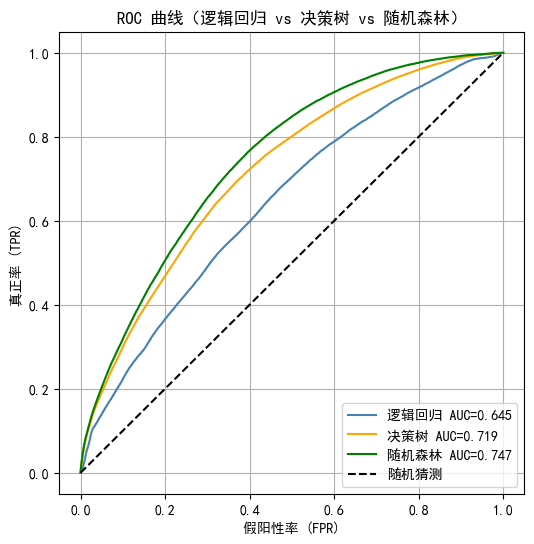

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC 曲线数据
fpr_lr, tpr_lr, _ = roc_curve(y_valid, p_valid)
fpr_dt, tpr_dt, _ = roc_curve(y_valid, p_valid_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_valid, p_valid_rf)

# 绘图
plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f"逻辑回归 AUC={auc:.3f}", color='steelblue')
plt.plot(fpr_dt, tpr_dt, label=f"决策树 AUC={auc_dt:.3f}", color='orange')
plt.plot(fpr_rf, tpr_rf, label=f"随机森林 AUC={auc_rf:.3f}", color='green')
plt.plot([0,1],[0,1], "k--", label="随机猜测")

plt.xlabel("假阳性率 (FPR)")
plt.ylabel("真正率 (TPR)")
plt.title("ROC 曲线（逻辑回归 vs 决策树 vs 随机森林）")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


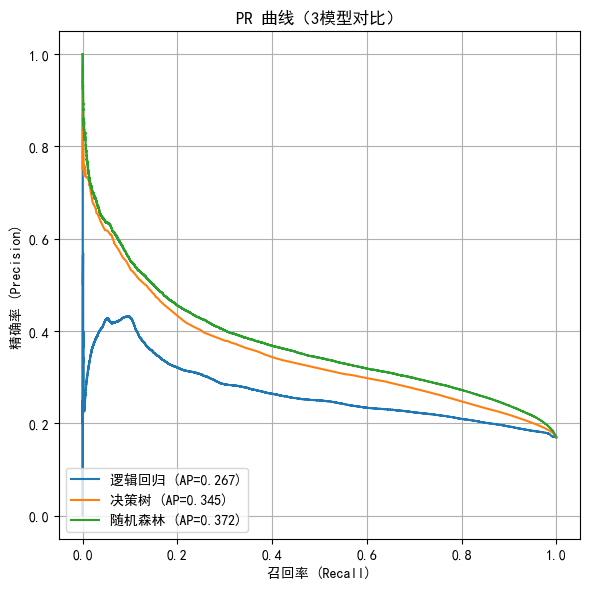

保存：fig_pr_lr_dt_rf.png


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.metrics import precision_recall_curve, average_precision_score

# 중국어/한글 폰트(가능한 경우) – 없으면 자동 대체되니 걱정 X
rcParams["font.sans-serif"] = ["SimHei", "Malgun Gothic", "AppleGothic", "Arial Unicode MS"]
rcParams["axes.unicode_minus"] = False

names = ["逻辑回归", "决策树", "随机森林"]
probs = [p_valid, p_valid_dt, p_valid_rf]

plt.figure(figsize=(6,6))
for name, p in zip(names, probs):
    prec, rec, _ = precision_recall_curve(y_valid, p)
    ap = average_precision_score(y_valid, p)  # PR AUC에 해당
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

plt.xlabel("召回率 (Recall)")
plt.ylabel("精确率 (Precision)")
plt.title("PR 曲线（3模型对比）")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_pr_lr_dt_rf.png", dpi=180)
plt.show()
print("保存：fig_pr_lr_dt_rf.png")


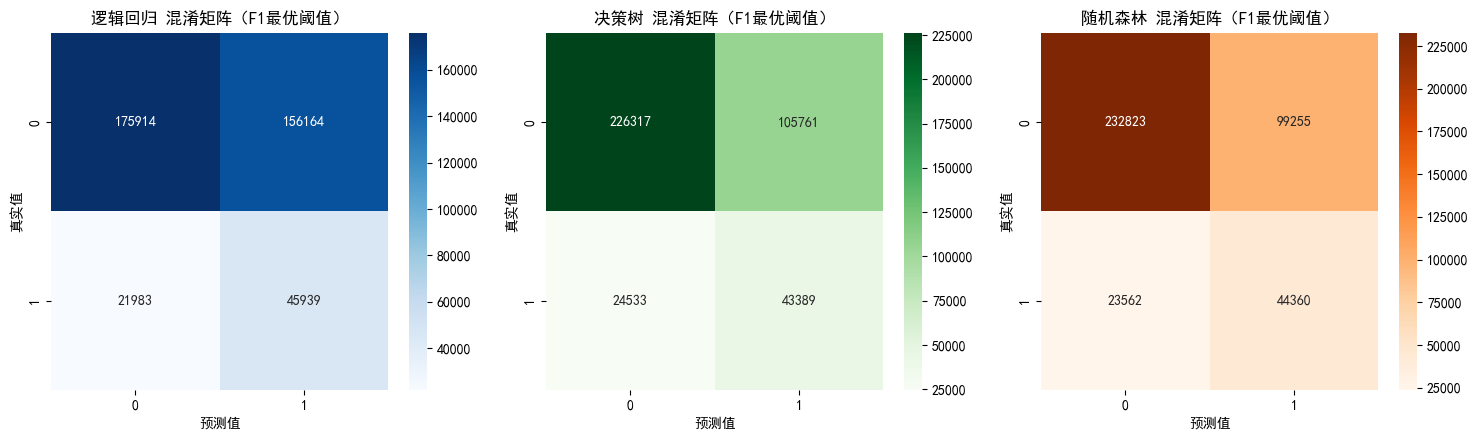

保存：fig_confusion_matrices_3models.png

F1最优阈值下的性能对比：
      模型    最佳阈值    最佳F1     精确率     召回率
0  逻辑回归  0.1581  0.3403  0.2273  0.6763
1   决策树  0.1942  0.3998  0.2909  0.6388
2  随机森林  0.5457  0.4194  0.3089  0.6531
保存：report_f1_threshold_stats.csv


In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
    i = int(np.argmax(f1))
    return float(thr[i]), float(f1[i]), float(prec[i]), float(rec[i])

# 모델별 최적 임계값/점수/혼동행렬 계산
stats = []
cms = []
for name, p in zip(names, probs):
    thr, f1, prec, rec = best_threshold_by_f1(y_valid, p)
    y_pred = (p >= thr).astype(int)
    cm = confusion_matrix(y_valid, y_pred)
    stats.append((name, thr, f1, prec, rec))
    cms.append(cm)

# 혼동행렬 3개 한 화면에
plt.figure(figsize=(15,4.5))
cm_titles = [f"{n} 混淆矩阵（F1最优阈值）" for n in names]
cm_cmaps  = ["Blues", "Greens", "Oranges"]

for i, (cm, title, cmap) in enumerate(zip(cms, cm_titles, cm_cmaps), start=1):
    plt.subplot(1,3,i)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=True,
                xticklabels=["0","1"], yticklabels=["0","1"])
    plt.title(title)
    plt.xlabel("预测值"); plt.ylabel("真实值")

plt.tight_layout()
plt.savefig("fig_confusion_matrices_3models.png", dpi=180)
plt.show()
print("保存：fig_confusion_matrices_3models.png")

# 표 형태로 성능 요약 출력
import pandas as pd
df_stats = pd.DataFrame(stats, columns=["模型","最佳阈值","最佳F1","精确率","召回率"])
df_stats = df_stats.assign(
    最佳阈值=lambda d: d["最佳阈值"].round(4),
    最佳F1=lambda d: d["最佳F1"].round(4),
    精确率=lambda d: d["精确率"].round(4),
    召回率=lambda d: d["召回率"].round(4)
)
print("\nF1最优阈值下的性能对比：\n", df_stats)
df_stats.to_csv("report_f1_threshold_stats.csv", index=False, encoding="utf-8-sig")
print("保存：report_f1_threshold_stats.csv")


保存：feature_importance_rf.csv
特征数： 25 ；前5：
              feature  importance  importance_pct
16      site_id_freq    0.102223       10.222318
12               C21    0.095623        9.562290
17  site_domain_freq    0.088846        8.884633
19       app_id_freq    0.082878        8.287790
5                C14    0.063931        6.393079


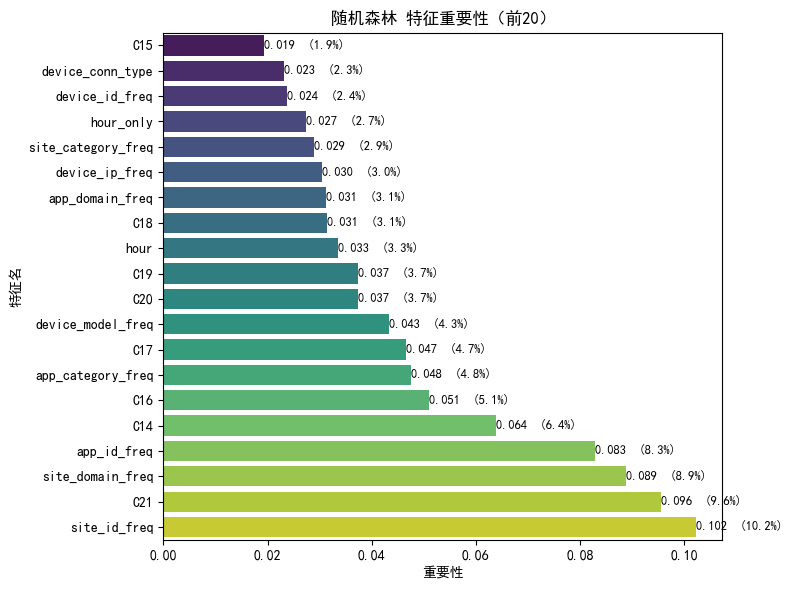

保存：fig_rf_feature_importance_top20.png


In [29]:
# ── 随机森林 特征重要性（前20） ─────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 중국어 폰트 설정 (윈도우)
rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
rcParams['axes.unicode_minus'] = False

# 1) 중요도 집계
importances = rf.feature_importances_
feat_names = np.array(X_train.columns)

feat_imp = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .assign(
        importance=lambda d: d["importance"].astype(float),
        importance_pct=lambda d: (d["importance"] / d["importance"].sum() * 100)
    )
)

# 2) 저장 (CSV)
feat_imp.to_csv("feature_importance_rf.csv", index=False, encoding="utf-8-sig")
print("保存：feature_importance_rf.csv")
print("特征数：", len(feat_imp), "；前5：\n", feat_imp.head())

# 3) 可视化（前20）
topN = 20
top_df = feat_imp.head(topN).iloc[::-1]  # barh 위에서 아래로 보기 좋게 역순

plt.figure(figsize=(8, 6))
sns.barplot(
    data=top_df,
    x="importance",
    y="feature",
    palette="viridis"
)
plt.xlabel("重要性")
plt.ylabel("特征名")
plt.title("随机森林 特征重要性（前20）")

# 막대 끝에 값 주석(퍼센트 표시)
for i, (imp, pct) in enumerate(zip(top_df["importance"], top_df["importance_pct"])):
    plt.text(imp, i, f"{imp:.3f}  ({pct:.1f}%)", va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.savefig("fig_rf_feature_importance_top20.png", dpi=180)
plt.show()
print("保存：fig_rf_feature_importance_top20.png")



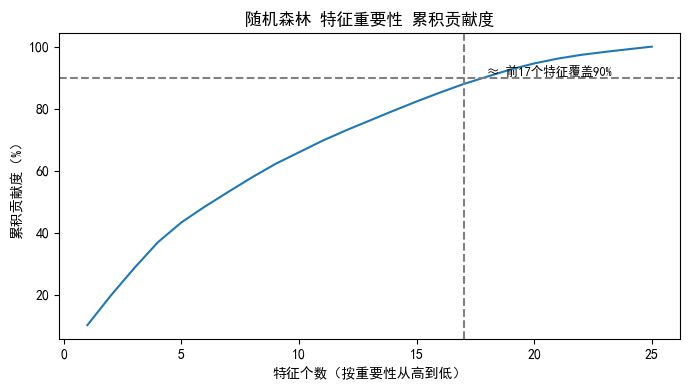

保存：fig_rf_feature_importance_cumsum.png


In [30]:
cum = feat_imp.assign(cum_pct=lambda d: d["importance_pct"].cumsum())
k90 = int((cum["cum_pct"] <= 90).sum())  # 90% 설명에 필요한 특성 수

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cum)+1), cum["cum_pct"])
plt.axhline(90, ls="--", c="grey")
plt.axvline(k90, ls="--", c="grey")
plt.title("随机森林 特征重要性 累积贡献度")
plt.xlabel("特征个数（按重要性从高到低）")
plt.ylabel("累积贡献度（%）")
plt.text(k90+1, 90.5, f"≈ 前{k90}个特征覆盖90%", fontsize=9)
plt.tight_layout()
plt.savefig("fig_rf_feature_importance_cumsum.png", dpi=180)
plt.show()
print("保存：fig_rf_feature_importance_cumsum.png")
